# Exploring marriages and divorces in Jamaica

Data from The Statistical Institute of Jamaica, OECD and the Groningen Growth and Development Centre.

First importing relevant libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sb

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

from pandas import DataFrame as df
import requests
from bs4 import BeautifulSoup

Getting data from the STATIN website

In [3]:
response = requests.get("https://www.datazoa.com/data/table.asp?a=view&th=2742AB0EE8&dzuuid=1838&uid=dzadmin")
content = response.content
soup = BeautifulSoup(content, 'html.parser')
results = soup.find(class_ = 'dz-embed')
content = results.find_all('span')

Cleaning the data

In [4]:
clean_data = ""
x = 0
frame = []
for data in content[:-16]:
    clean_data += data.text.strip() + '|'
    clean_data = clean_data.replace(",", "")
    clean_data = clean_data.replace(".0", "")
    x += 1
    if x == 6:
        frame.append(list(map(int,clean_data.split('|')[:-1])))
        #frame.append(clean_data.split('|')[:-1])
        clean_data = ""
        x = 0


Great, now to split up, label and put into a Pandas DataFrame

In [5]:
males = frame[0:7]
females = frame[7:]
columns = [x for x in range(2013,2019)]
arr = np.array(males + females)

side = ['Total', 'Under_20', '20-29', '30-39', '40-49', '50-59', '60_and_over']
data = df(arr, columns=columns, index=side+side)
data



,2013,2014,2015,2016,2017,2018
Total,18835,18699,18323,17609,17411,16719
Under_20,39,39,34,25,31,20
20-29,4905,4780,4531,4277,4219,3958
30-39,6877,6845,6614,6157,5923,5685
40-49,4033,4138,4087,3989,3927,3738
50-59,2113,2035,2124,2214,2236,2328
60_and_over,868,862,933,947,1075,990
Total,18835,18699,18319,17609,17411,16719
Under_20,188,176,190,133,139,120
20-29,6596,6489,6150,5738,5549,5192


Time to have some fun with the numbers

<AxesSubplot:>

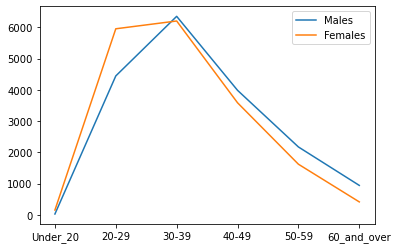

In [6]:
males = data.loc[data[2013] < 18000].head(6)
males

females = data.loc[data[2013] < 18000].tail(6)
females

males['mean'] = males.mean(axis=1)
males
females['mean'] = females.mean(axis=1)

cross = pd.concat([males['mean'], females['mean']], axis=1, keys=['Males', 'Females'])
cross.plot()

So women seem to get married earlier in life, but do not get married as readily later in life as men do. At around age 30, both sexes marry at similar rates.

<AxesSubplot:>

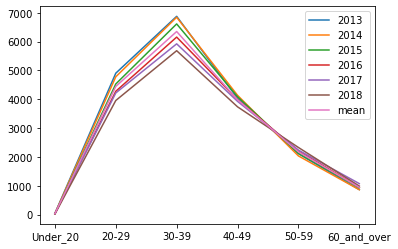

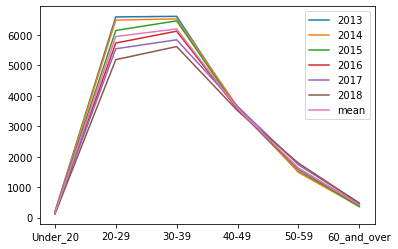

In [7]:
males.plot()
females.plot()

These graphs show that marriage rates were higher in earlier than later years on the data set. Noticeably more women in their 30s got married in their 20s due to the positive slope between those two years becoming more prominent.

Let's import some economic data to see if we can find any insights. Starting with GDP data from STATIN, I'm just copying and pasting for expediency right now. 

In [8]:
gdp = pd.Series(np.array([1501306,1599279,1676198,1830764,1931886]), index=columns[1:])
#From https://statinja.gov.jm/NationalAccounting/Annual/NewAnnualGDP.aspx
gdp

2014    1501306
2015    1599279
2016    1676198
2017    1830764
2018    1931886
dtype: int32

In [9]:
marriages = pd.Series(males.sum(axis=0)[1:-1], dtype=int)
marriages.corr(gdp)

-0.9724644085601676

Although further statistical analysis is necessary to contextualize this result (due to the small sample size), there seems to be a very strong negative correlation between GDP and marriage rates. Who would have thought? :)

<AxesSubplot:>

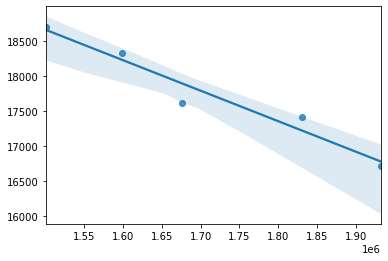

In [10]:
sb.regplot(x=gdp, y=marriages)

This helps to visualize how marriage rates declined with GDP. Testing on a larger dataset would yield more insightful results, but alas this was me practicing some data cleaning and exploratory analysis.

# Looking at the world
Using OECD (https://www.oecd.org/els/family/database.htm) and Penn World Table (https://www.rug.nl/ggdc/productivity/pwt/) data from the Groningen Institute

In [293]:
#Importing and cleaning the data
data = 'rgdpe'
mrates = pd.read_csv("marriagerates.csv")
mrates = mrates.replace(0,0.0)
econdata = pd.read_csv("econdata.csv") 
country_by_gdp = econdata[['country', 'year', data]].copy()
country_by_gdp = country_by_gdp.set_index('year')
country_by_gdp = country_by_gdp.fillna(0)

#About to be a little eccentric but this is the fastest way I saw to isolate GDP data in a useful format
arr = []
c = []
x = 0
for country in country_by_gdp[data]:
    c.append(country)
    x += 1
    if x == 70:
        arr.append(c)
        x = 0
        c = []
cbg = df(np.array(arr),columns=list(map(str,[i for i in range(1950,2020)])), index=country_by_gdp['country'].unique(), dtype=float)

mrates = mrates.set_index('Country')
mrates = mrates.drop(labels = 'Note', axis=1)

#Cutting away the non-OECD countries and others that don't correspond

for country in cbg.index:
    if country not in mrates.index:
        cbg = cbg.drop(labels = country, axis = 0)
        
for country in mrates.index:
    if country not in cbg.index:
        mrates = mrates.drop(labels = country, axis = 0)

cbg = cbg.drop(labels= list(map(str,range(1950,1960))), axis = 1)
cbg = cbg.drop(labels= ['2018', '2019'], axis = 1)
cbg.columns.name = 'Country'
cbg.sort_index(inplace=True)
mrates.sort_index(inplace=True)
mrates = mrates.replace(0,0.0)
mrates = mrates.replace('..',0.0)
mrates = mrates.astype(float)
marriage_and_gdp = mrates.corrwith(cbg,drop=True)
marriage_and_gdp

1960   -0.219443
1961   -0.245635
1962   -0.244276
1963   -0.210590
1964   -0.226712
1965   -0.234657
1966   -0.238587
1967   -0.243403
1968   -0.238516
1969   -0.243465
1970    0.080452
1971   -0.237726
1972   -0.230091
1973   -0.246670
1974   -0.263346
1975   -0.275901
1976   -0.274251
1977   -0.280994
1978   -0.282314
1979   -0.276833
1980   -0.287122
1981   -0.294764
1982   -0.299461
1983   -0.300917
1984   -0.298165
1985    0.076262
1986   -0.317560
1987   -0.318404
1988   -0.307700
1989   -0.303213
1990   -0.343412
1991    0.026683
1992    0.029173
1993    0.057704
1994    0.078423
1995    0.085636
1996    0.104189
1997    0.085507
1998    0.069419
1999    0.072216
2000    0.055654
2001    0.062718
2002    0.034398
2003    0.034853
2004   -0.003620
2005   -0.044706
2006   -0.078963
2007   -0.094638
2008   -0.130701
2009   -0.132454
2010    0.227406
2011    0.228932
2012    0.227929
2013   -0.100007
2014   -0.163106
2015   -0.172131
2016   -0.168778
2017   -0.136579
dtype: float64

In [287]:
marriage_and_gdp.mean()

-0.12710786989351372

<AxesSubplot:>

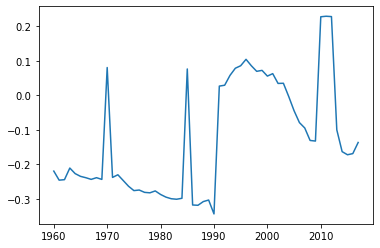

In [290]:
marriage_and_gdp.plot()

<AxesSubplot:>

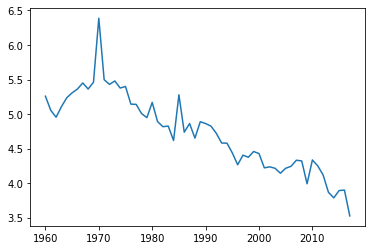

In [249]:
mrates.mean().plot()

<AxesSubplot:xlabel='Country'>

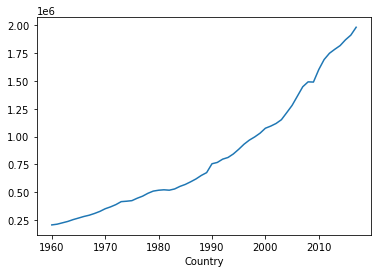

In [251]:
cbg.mean().plot()